# Nethermind's benchmarking data - pure compute opcodes analysis

#### Maria Silva, September 2025

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

## Load data

In this analysis, we are using data generated by running the [EEST benchmark suite](https://github.com/ethereum/execution-spec-tests/tree/main/tests/benchmark) with the [Nethermind benchmarking tooling](https://github.com/NethermindEth/gas-benchmarks). We extracted this data in 22-09-2025.

In [3]:
# Main directories
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")

In [4]:
with open(os.path.join(data_dir, "compute_ops.txt"), "r") as f:
    compute_ops_list = f.read().splitlines()

compute_ops_list = [op for op in compute_ops_list if ("#" not in op) and (op!="")]
compute_ops_list = [op.split(" = ")[0] for op in compute_ops_list]

In [5]:
df = pd.read_csv(os.path.join(data_dir, "min_mgas_s_by_test_and_client_2025-09-22.csv"))
df = df.melt(
    id_vars=["test_title"], var_name="client", value_name="mgas/s"
).sort_values(by="mgas/s")
# Parse test title
df["test_file"] = (
    df["test_title"].str.replace("tests_benchmark_", "").str.split(".py").str[0]
)
df["test_name"] = (
    df["test_title"]
    .str.split(".py__")
    .str[1]
    .str.split("[")
    .str[0]
)
df["test_params"] = (
    df["test_title"]
    .str.split("[")
    .str[1]
    .str.split("]")
    .str[0]
    .str.split("engine_x")
    .str[1]
    .str[1:]
)
df["test_fork"] = df["test_title"].str.split("fork_").str[1].str.split("-").str[0]
# Parse opcodes
df["test_opcode"] = df["test_params"].str.extract(r"(?:opcode_|op_)([^-]+)")
df["test_opcode"] = np.where(df["test_name"]=="test_worst_modexp", "MODEXP", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"].str.contains("selfdestruct"), "SELFDESTRUCT", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_calldatacopy", "CALLDATACOPY", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_mcopy", "MCOPY", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_codecopy", "CODECOPY", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_returndatacopy", "RETURNDATACOPY", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"].str.contains("returndatasize"), "RETURNDATASIZE", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"].str.contains("extcodecopy"), "EXTCODECOPY", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_calldataload", "CALLDATALOAD", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_keccak", "KECCAK", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_shifts", df["test_params"].str[-3:], df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_selfbalance", "SELFBALANCE", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_msize", "MSIZE", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_jumpdests", "JUMPDEST", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"].str.contains("jumpi"), "JUMPI", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_jumps", "JUMP", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_tstore", "TSTORE", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_tload", "TLOAD", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("SSTORE"), "SSTORE", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("SLOAD"), "SLOAD", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_log_opcodes", "LOG", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_calldatasize", "CALLDATASIZE", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_blobhash", "BLOBHASH", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_blockhash", "BLOCKHASH", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_worst_callvalue", "CALLVALUE", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("bn128_add"), "ecAdd", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("bn128_mul"), "ecMul", df["test_opcode"])
df["test_opcode"] = np.where((df["test_params"].str.contains("bn128")) & (df["test_params"].str.contains("pairing")), "ecPairing", df["test_opcode"])
df["test_opcode"] = np.where(df["test_name"]=="test_amortized_bn128_pairings", "ecPairing", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("point_evaluation"), "point evaluation", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("blake2f"), "blake2f", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("ecrecover"), "ecRecover", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("SHA2-256"), "SHA2-256", df["test_opcode"]) 
df["test_opcode"] = np.where(df["test_params"].str.contains("RIPEMD-160"), "RIPEMD-160", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("IDENTITY"), "identity", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("bls12_g1add"), "BLS12_G1ADD", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("bls12_g1msm"), "BLS12_G1MSM", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("bls12_g2add"), "BLS12_G2ADD", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("bls12_g2msm"), "BLS12_G2MSM", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("bls12_pairing_check"), "BLS12_PAIRING_CHECK", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("bls12_fp_to_g1"), "BLS12_MAP_FP_TO_G1", df["test_opcode"])
df["test_opcode"] = np.where(df["test_params"].str.contains("bls12_fp_to_g2"), "BLS12_MAP_FP2_TO_G2", df["test_opcode"])
df = df.drop(columns=["test_title"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2305 entries, 441 to 1853
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client       2305 non-null   object 
 1   mgas/s       2305 non-null   float64
 2   test_file    2305 non-null   object 
 3   test_name    2305 non-null   object 
 4   test_params  2305 non-null   object 
 5   test_fork    2305 non-null   object 
 6   test_opcode  2260 non-null   object 
dtypes: float64(1), object(6)
memory usage: 144.1+ KB


In [6]:
# Filter for pure compute opcodes (ignoring precompiles)
compute_df = df[df["test_opcode"].isin(compute_ops_list)]
# Keep only the worst client for each test
worse_compute_df = (
    compute_df.groupby(["test_file", "test_name", "test_params", "test_fork", "test_opcode"])[
        "mgas/s"
    ]
    .min()
    .reset_index()
)

## Operations with varying inputs

In [7]:
# Check for varuing inputs in tests
vary_ops_df = worse_compute_df.groupby("test_opcode").size().sort_values(ascending=False)
vary_ops_df = vary_ops_df[vary_ops_df>1]
vary_ops_df

test_opcode
RETURNDATASIZE    5
MSIZE             5
MOD               5
SMOD              5
CALLVALUE         4
MULMOD            4
ADDMOD            4
BLOBHASH          4
TLOAD             4
TSTORE            4
CALLDATALOAD      3
CALLDATASIZE      3
SDIV              2
SAR               2
SHR               2
JUMPI             2
DIV               2
dtype: int64

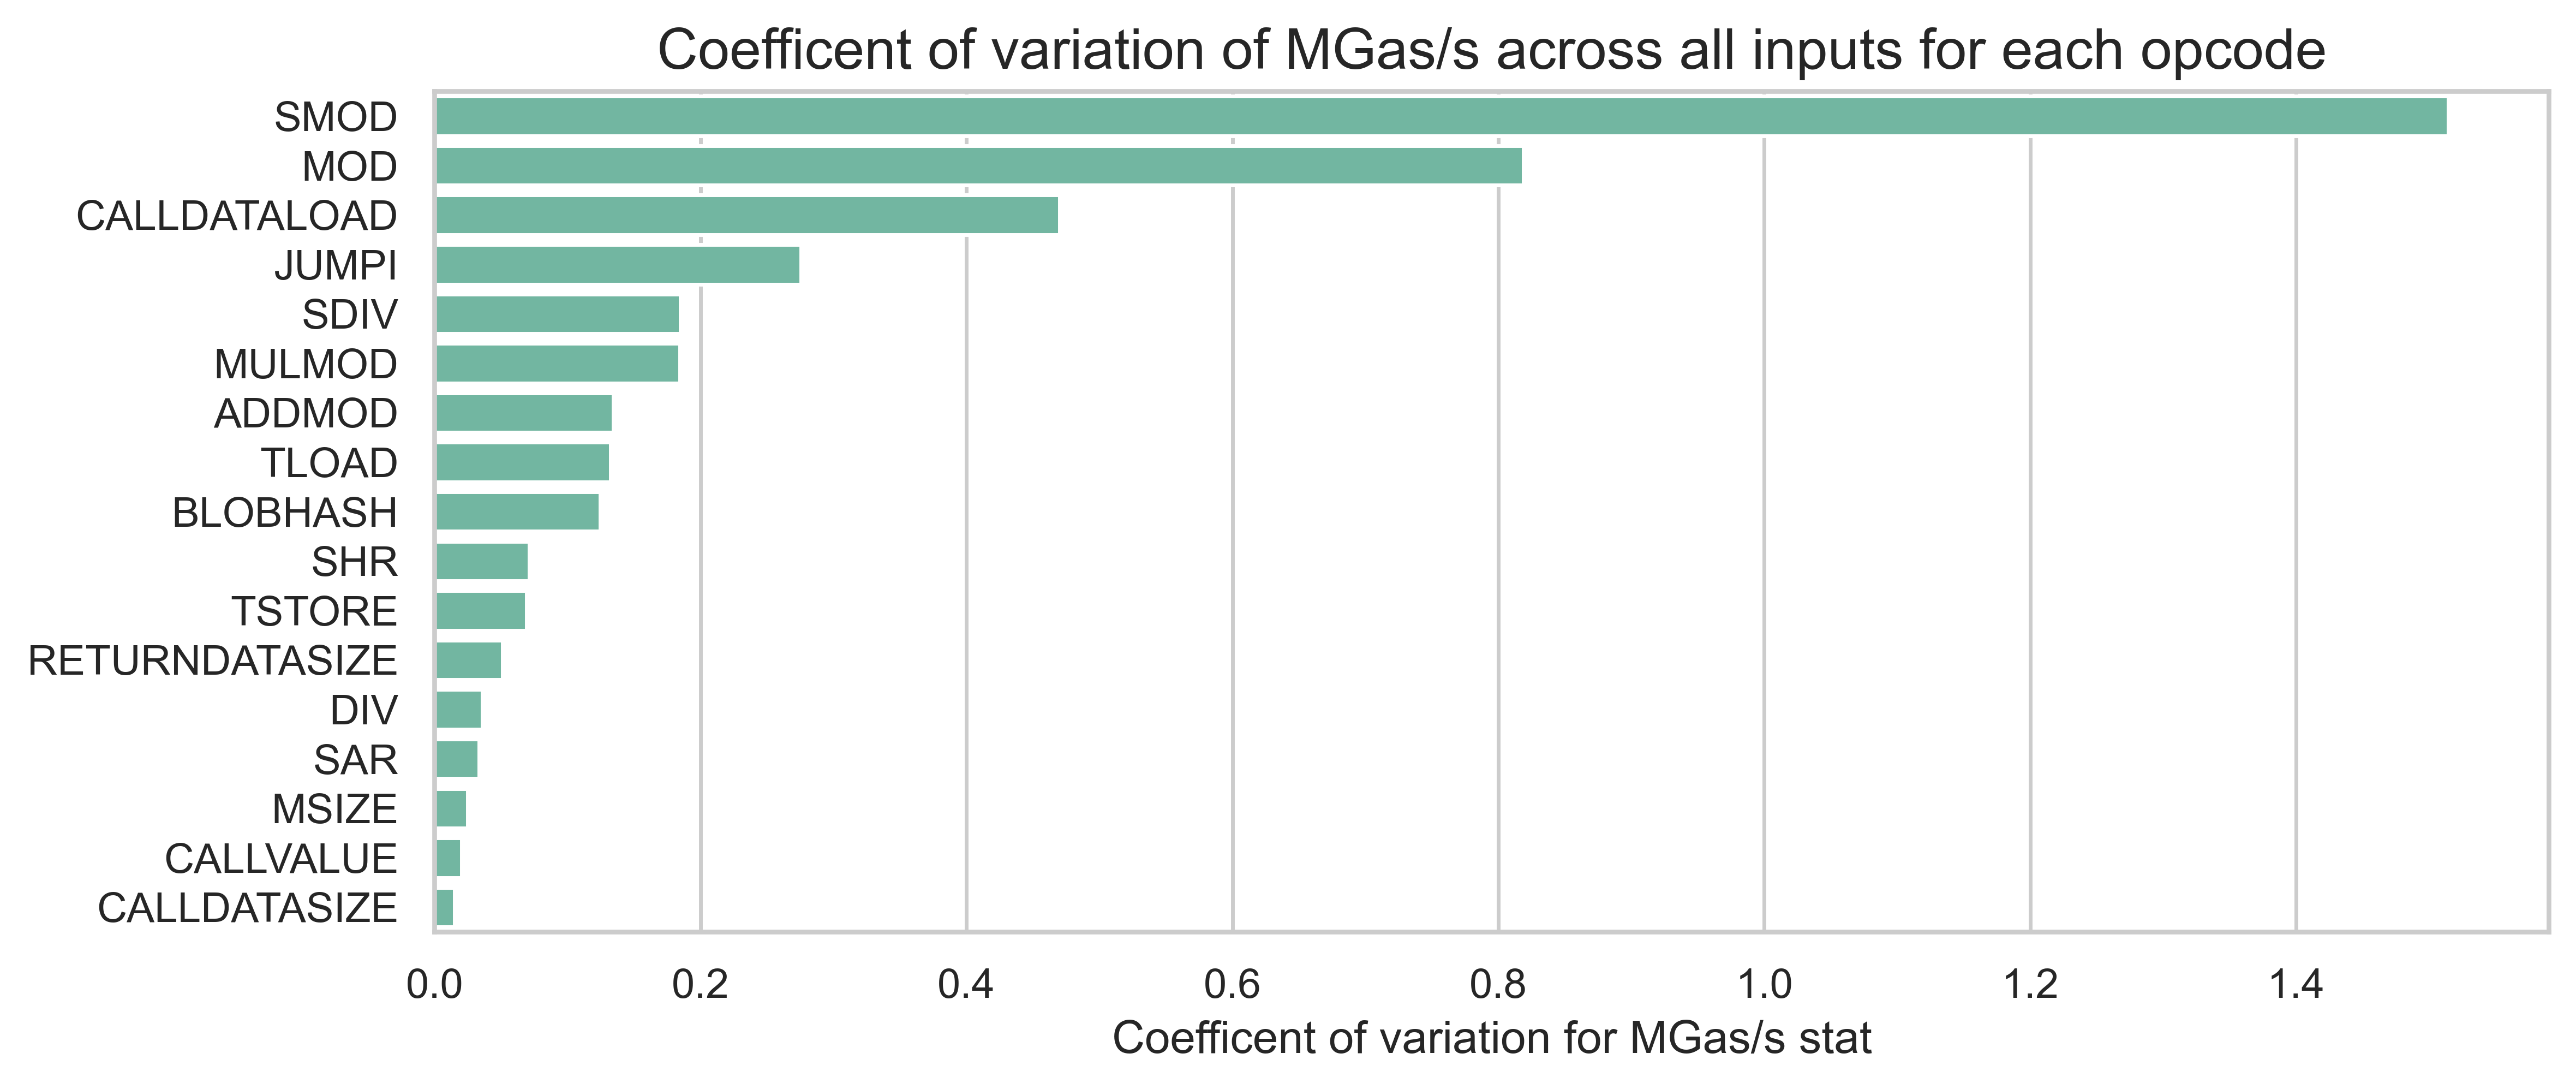

In [8]:
var_val_df = worse_compute_df.groupby("test_opcode")["mgas/s"].agg(["mean", "std"]).dropna()
var_val_df["cv"] = var_val_df["std"]/var_val_df["mean"]

plt.figure(figsize=(10, 4))
sns.barplot(
    data=var_val_df.sort_values(by="cv", ascending=False),
    x="cv",
    y="test_opcode",
)
plt.title("Coefficent of variation of MGas/s across all inputs for each opcode")
plt.ylabel("")
plt.xlabel("Coefficent of variation for MGas/s stat")
plt.show()

`SMOD`, `MOD` and `CALLDATALOAD` have significantly high variance in their mgas/s values. For `SMOD` and `MOD`, the difference seems to come mostly from the two different tests done, namely `test_worst_binop_simple` and `test_worst_mod`. Not sure what is causing the difference though.

In [9]:
worse_compute_df[worse_compute_df["test_opcode"]=="SMOD"]

,test_file,test_name,test_params,test_fork,test_opcode,mgas/s
20,test_worst_compute,test_worst_binop_simple,from_state_test-opcode_SMOD-,Prague,SMOD,138.0
61,test_worst_compute,test_worst_mod,from_state_test-op_SMOD-mod_bits_127,Prague,SMOD,10.3
62,test_worst_compute,test_worst_mod,from_state_test-op_SMOD-mod_bits_191,Prague,SMOD,10.9
63,test_worst_compute,test_worst_mod,from_state_test-op_SMOD-mod_bits_255,Prague,SMOD,12.0
64,test_worst_compute,test_worst_mod,from_state_test-op_SMOD-mod_bits_63,Prague,SMOD,14.9


In [10]:
worse_compute_df[worse_compute_df["test_opcode"]=="MOD"]

,test_file,test_name,test_params,test_fork,test_opcode,mgas/s
9,test_worst_compute,test_worst_binop_simple,from_state_test-opcode_MOD-,Prague,MOD,43.3
57,test_worst_compute,test_worst_mod,from_state_test-op_MOD-mod_bits_127,Prague,MOD,10.3
58,test_worst_compute,test_worst_mod,from_state_test-op_MOD-mod_bits_191,Prague,MOD,10.1
59,test_worst_compute,test_worst_mod,from_state_test-op_MOD-mod_bits_255,Prague,MOD,11.4
60,test_worst_compute,test_worst_mod,from_state_test-op_MOD-mod_bits_63,Prague,MOD,12.9


As for the `CALLDATALOAD`, the difference comes from the different input sizes used in the tests. the empty input test is slower, followed by the zero-loop and the one-loop.

In [11]:
worse_compute_df[worse_compute_df["test_opcode"]=="CALLDATALOAD"]

,test_file,test_name,test_params,test_fork,test_opcode,mgas/s
27,test_worst_compute,test_worst_calldataload,from_state_test-empty,Prague,CALLDATALOAD,60.1
28,test_worst_compute,test_worst_calldataload,from_state_test-one-loop,Prague,CALLDATALOAD,27.0
29,test_worst_compute,test_worst_calldataload,from_state_test-zero-loop,Prague,CALLDATALOAD,29.9


For the remaining of the analysis, we will keep only the worst-case scenario for each opcode.

## Relative costs and ms/gas

In [12]:
rel_df = (
    worse_compute_df.groupby("test_opcode")["mgas/s"]
    .min()
    .reset_index()
    .sort_values(by="mgas/s", ascending=False)
)
rel_df["ms/gas"] = 1 / rel_df["mgas/s"]
fastest_op_time = rel_df.loc[rel_df["mgas/s"].idxmax()]["ms/gas"]
rel_df["ratio_to_fastest"] = rel_df["ms/gas"] / fastest_op_time
rel_df.head(10)

,test_opcode,mgas/s,ms/gas,ratio_to_fastest
7,BLOCKHASH,376.0,0.002660,1.000000
114,TLOAD,191.0,0.005236,1.968586
103,SWAP15,173.0,0.005780,2.173410
115,TSTORE,168.0,0.005952,2.238095
104,SWAP16,166.0,0.006024,2.265060
102,SWAP14,162.0,0.006173,2.320988
101,SWAP13,154.0,0.006494,2.441558
100,SWAP12,152.0,0.006579,2.473684
99,SWAP11,152.0,0.006579,2.473684
30,DUP7,138.0,0.007246,2.724638


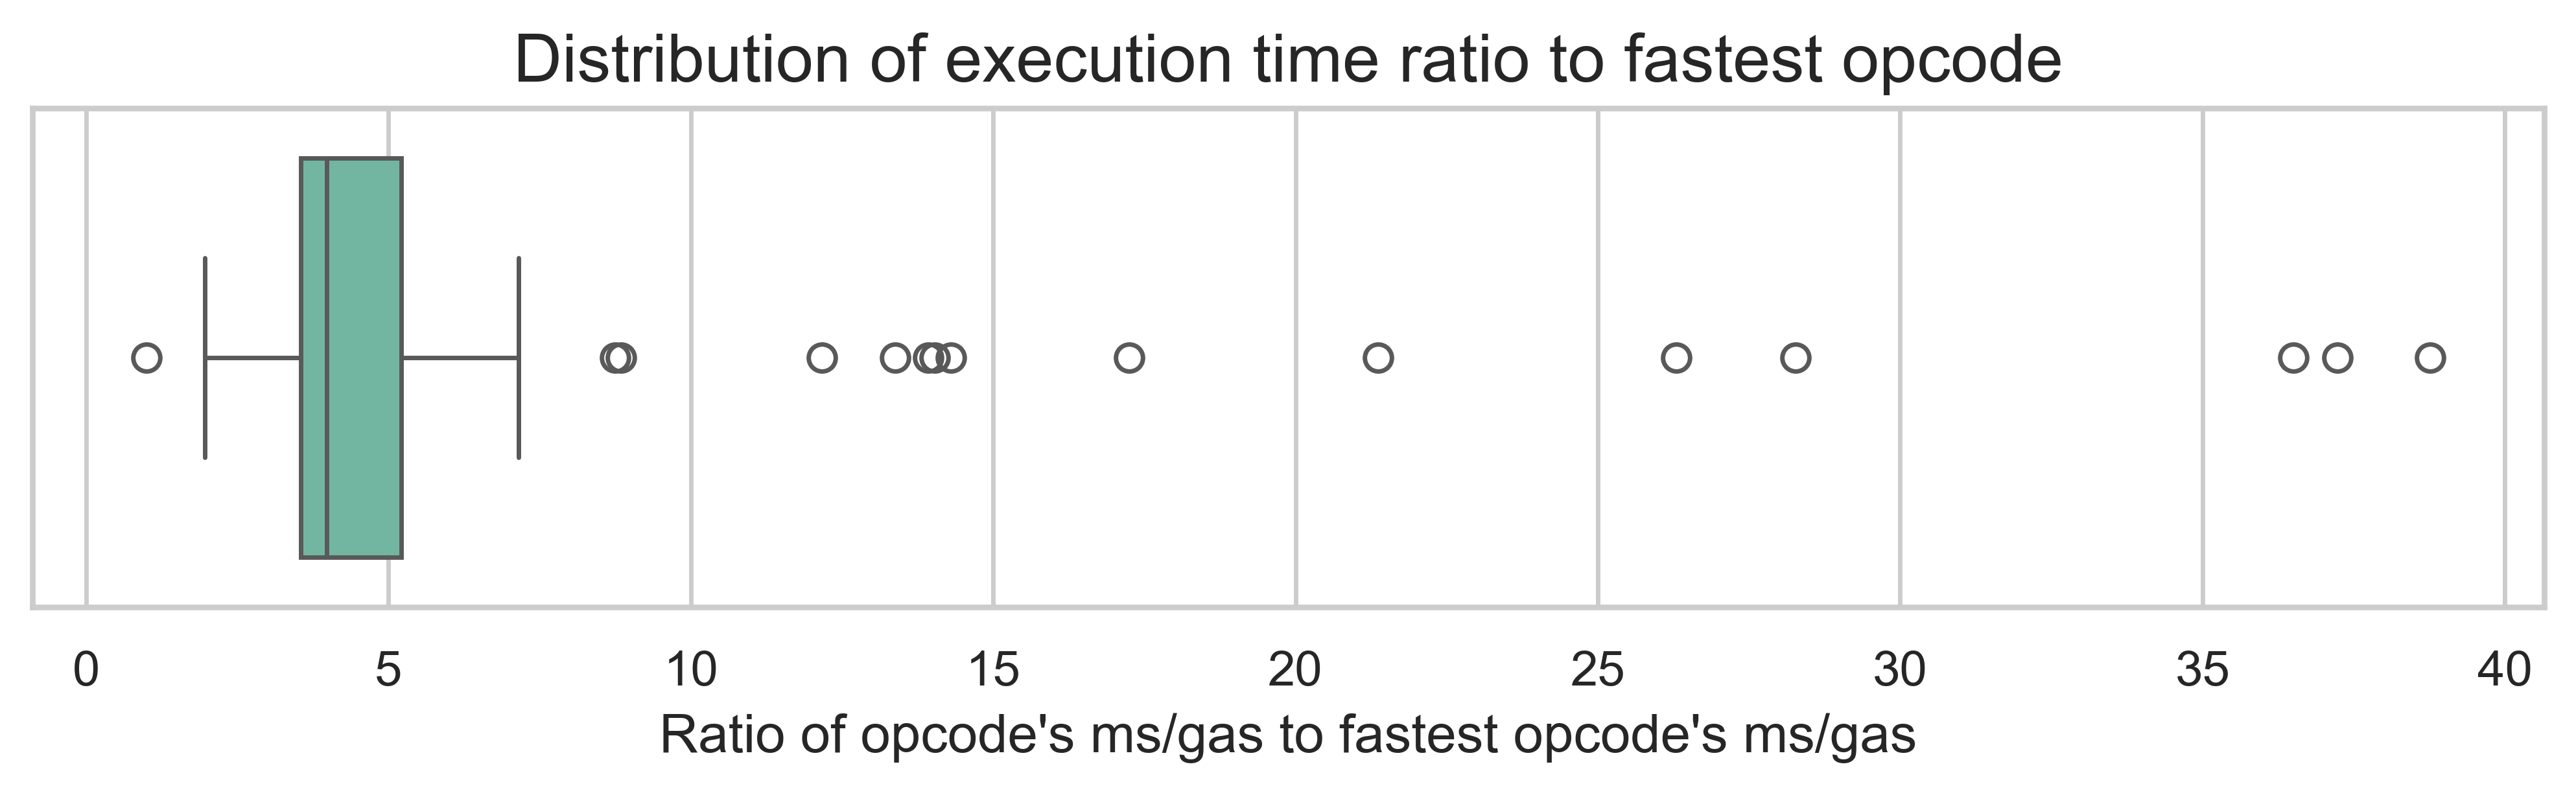

In [13]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=rel_df,
    x="ratio_to_fastest"
)
plt.title("Distribution of execution time ratio to fastest opcode")
plt.ylabel("")
plt.xlabel("Ratio of opcode's ms/gas to fastest opcode's ms/gas")
plt.show()

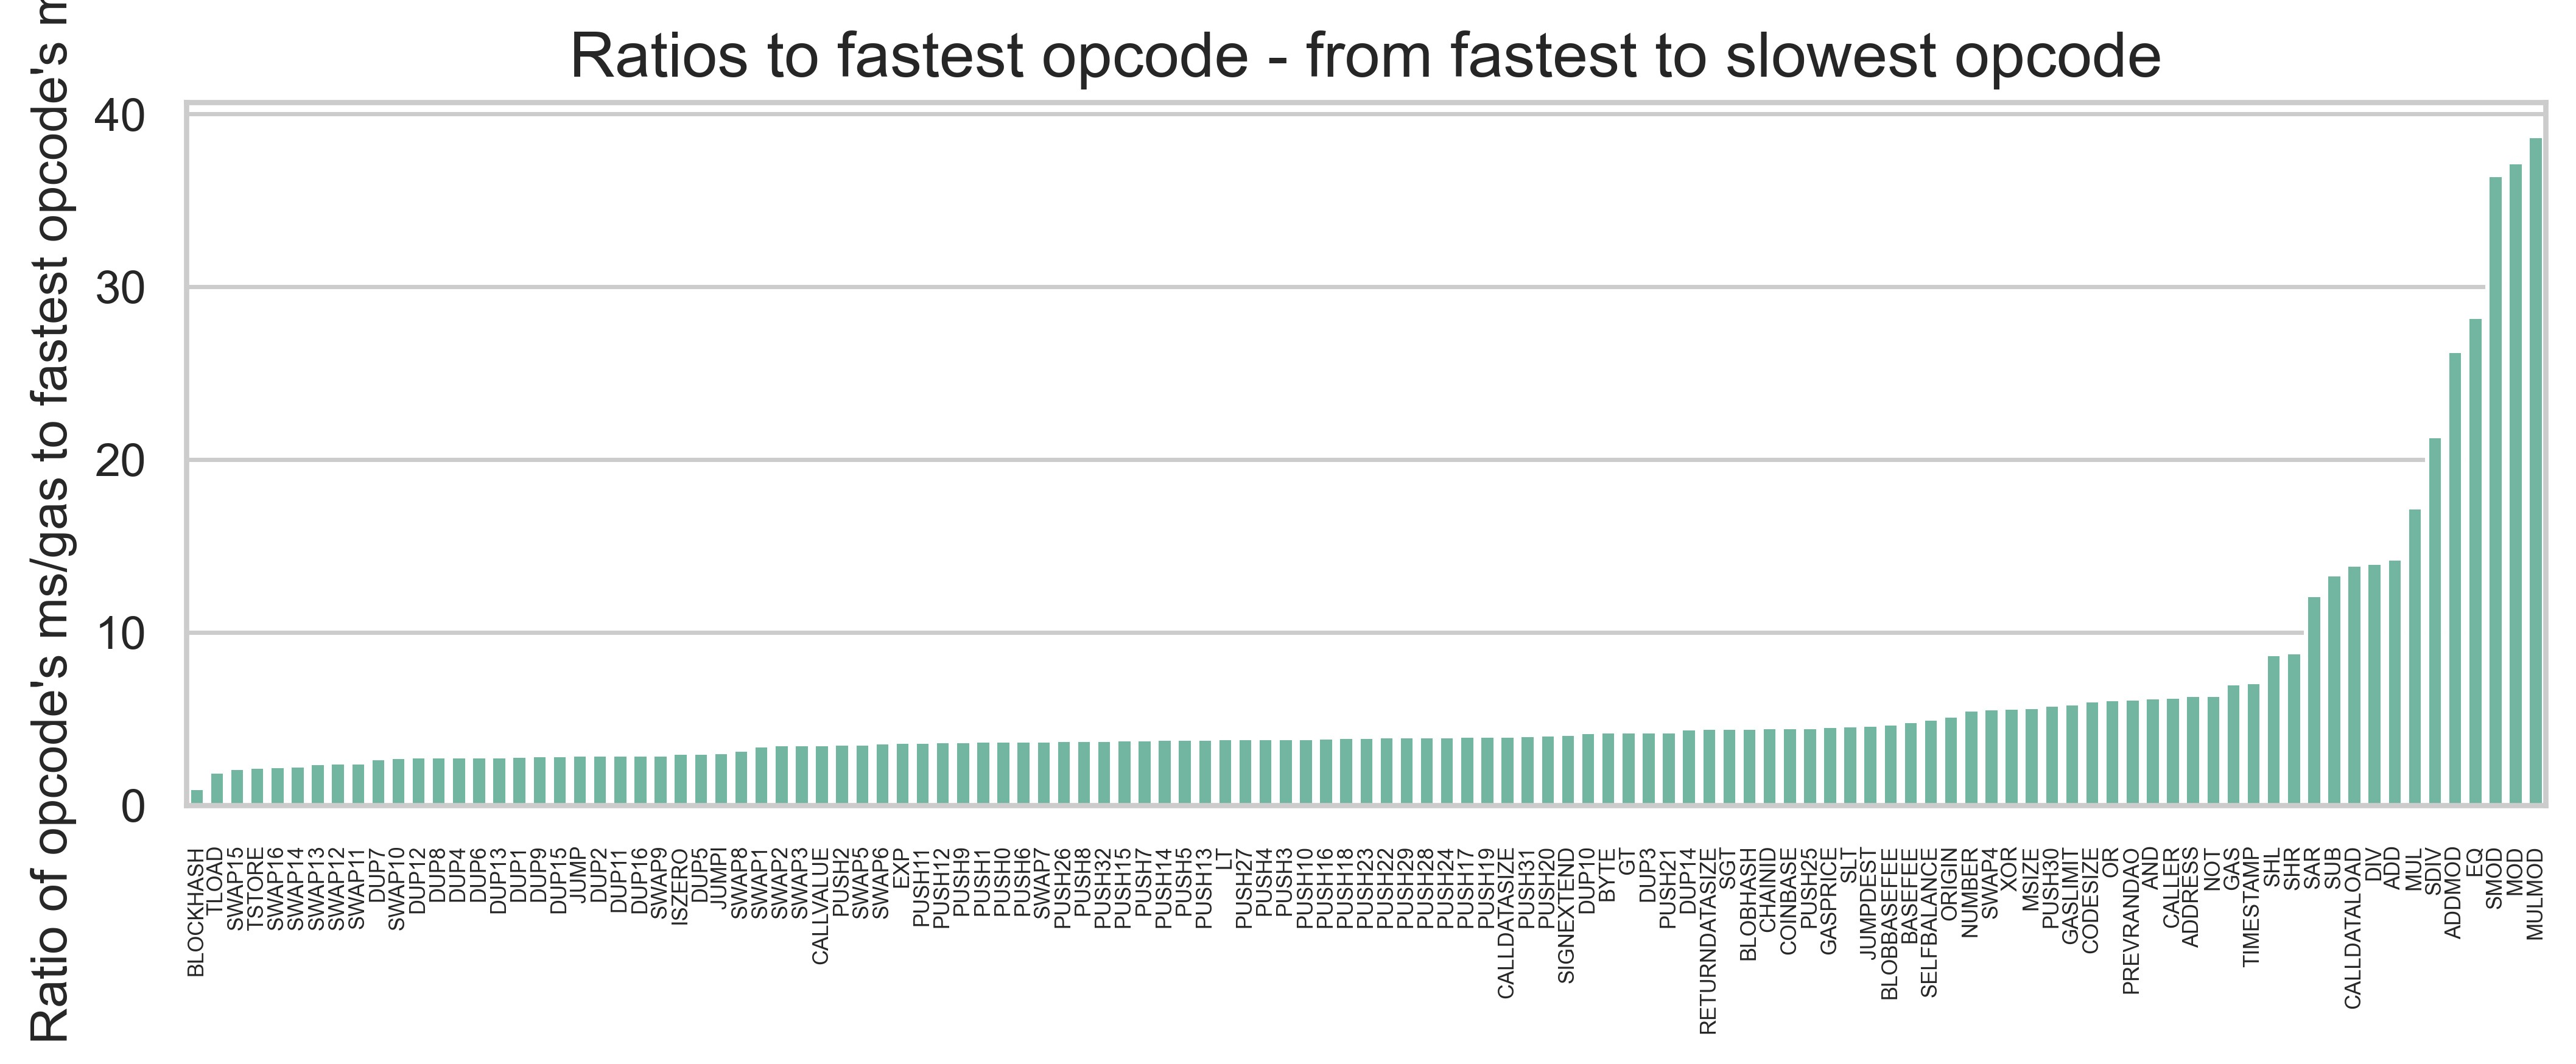

In [14]:
plt.figure(figsize=(10, 3))
sns.barplot(
    data=rel_df,
    y="ratio_to_fastest",
    x="test_opcode",
)
plt.title("Ratios to fastest opcode - from fastest to slowest opcode")
plt.xlabel("")
plt.ylabel("Ratio of opcode's ms/gas to fastest opcode's ms/gas")
plt.xticks(rotation=90, fontsize=5)
plt.show()

## Anchoring on ecRecover

In [15]:
worse_ecRecover_mgs = df[df["test_opcode"]=="ecRecover"]["mgas/s"].min()
worse_ecRecover_msgas = 1 / worse_ecRecover_mgs

rel_df["ratio_to_ecRecover"] = rel_df["ms/gas"] / worse_ecRecover_msgas
rel_df["new_gas_price"] = rel_df["ratio_to_ecRecover"]*3000

rel_df

,test_opcode,mgas/s,ms/gas,ratio_to_fastest,ratio_to_ecRecover,new_gas_price
7,BLOCKHASH,376.0,0.002660,1.000000,0.137500,412.500000
114,TLOAD,191.0,0.005236,1.968586,0.270681,812.041885
103,SWAP15,173.0,0.005780,2.173410,0.298844,896.531792
115,TSTORE,168.0,0.005952,2.238095,0.307738,923.214286
104,SWAP16,166.0,0.006024,2.265060,0.311446,934.337349
...,...,...,...,...,...,...
1,ADDMOD,14.3,0.069930,26.293706,3.615385,10846.153846
33,EQ,13.3,0.075188,28.270677,3.887218,11661.654135
95,SMOD,10.3,0.097087,36.504854,5.019417,15058.252427
44,MOD,10.1,0.099010,37.227723,5.118812,15356.435644


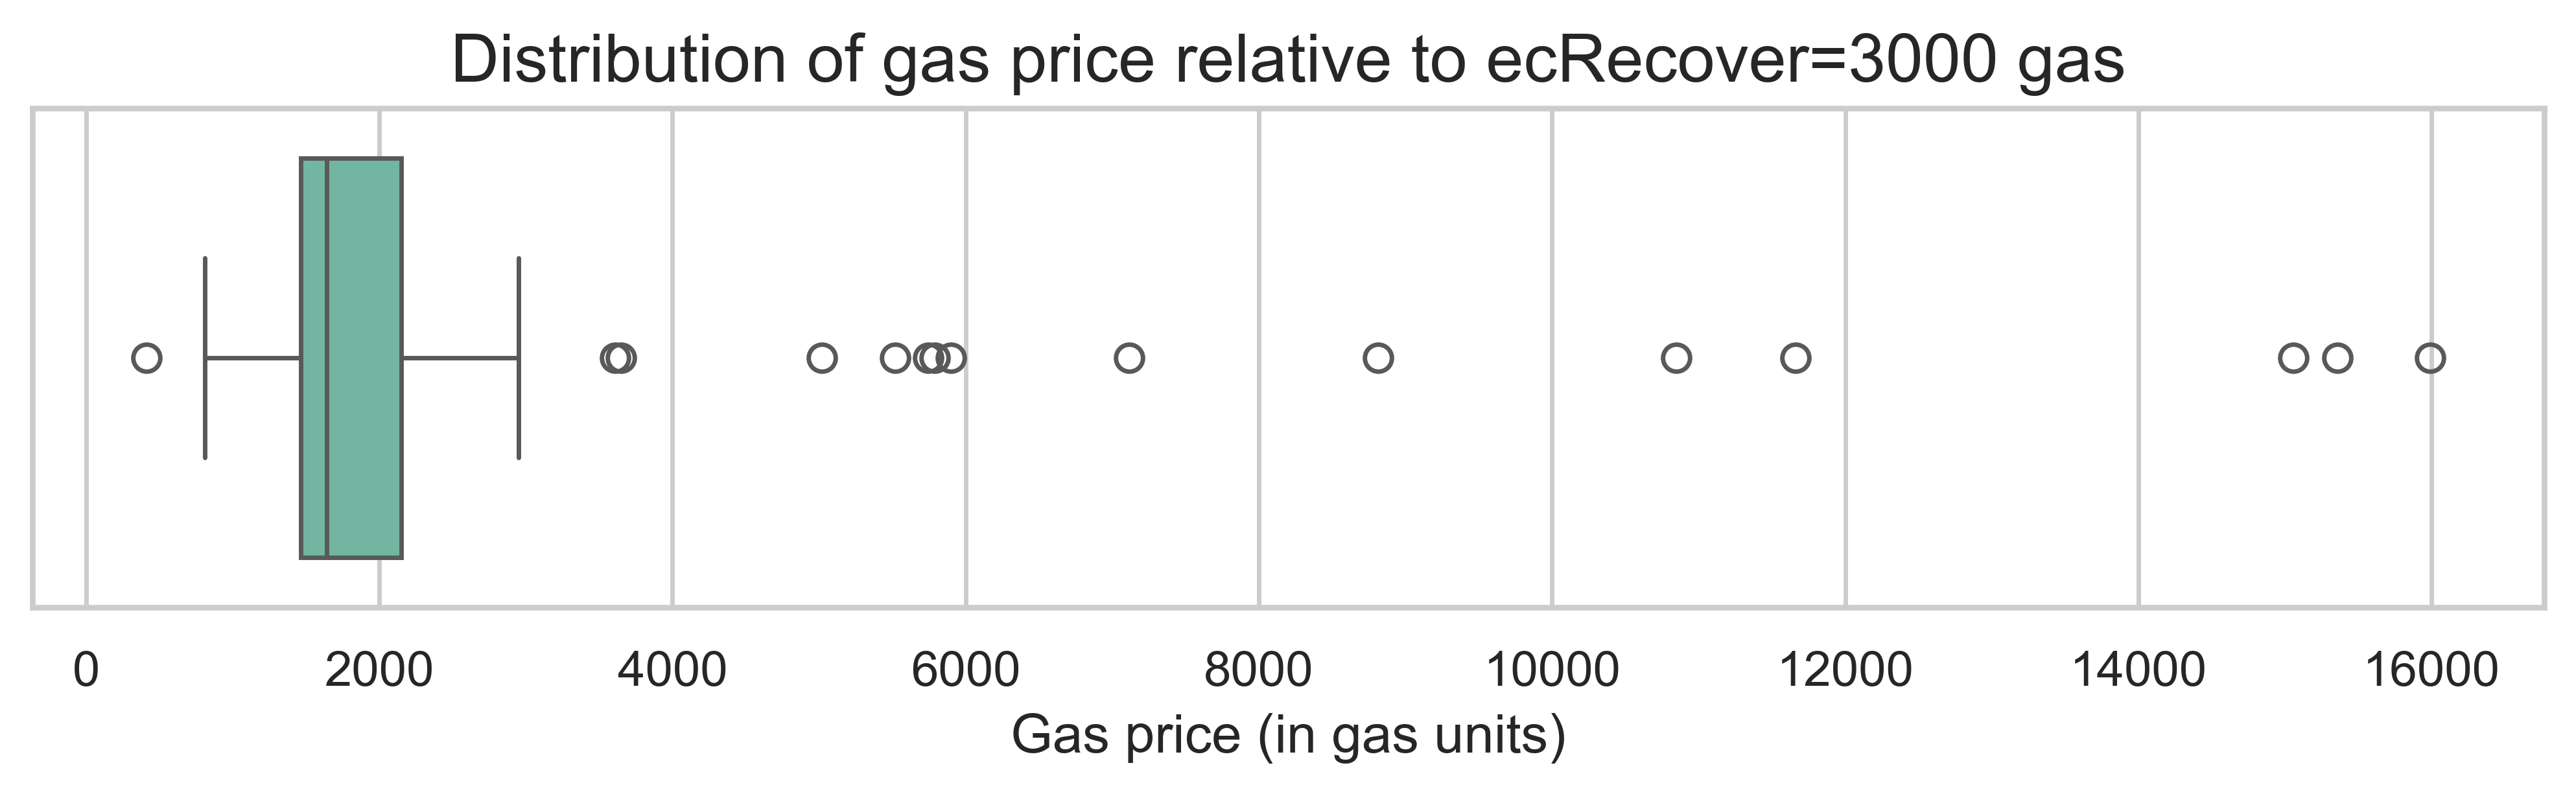

In [16]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=rel_df,
    x="new_gas_price"
)
plt.title("Distribution of gas price relative to ecRecover=3000 gas")
plt.ylabel("")
plt.xlabel("Gas price (in gas units)")
plt.show()